In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
# import roslibpy
from scipy.interpolate import interp1d
import rosbag
import math
import h5py
import matplotlib.pylab as plt

#sys.path.insert(0, '/media/abdulla/Seagate Expansion Drive/DVS research/DATA/contact estimation/')
from EventPreProcess import EventPreProcess
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped
from sensor_msgs.msg import Image
from cv_bridge import CvBridge

In [2]:
#parameters of processing
frequency = 10 #Hz
bag_file_name = "Halwani's_rosbag.bag"
h5_file_name = 'New.hdf5'
examples_per_edge = 1

In [3]:
bag_file = rosbag.Bag(bag_file_name)

frames = []
frames_ts = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []
bridge = CvBridge()


#generate labels
possible_angle = [0.075, 0.15]
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

#TODO: remove this case
#list_of_rotations[8] = [-0.15, 0, 0]

print(list_of_rotations)


[[0, 0, 0], [0.053033008588991064, 0.05303300858899106, 0], [0.10606601717798213, 0.10606601717798211, 0], [4.592425496802574e-18, 0.075, 0], [9.184850993605149e-18, 0.15, 0], [-0.05303300858899106, 0.053033008588991064, 0], [-0.10606601717798211, 0.10606601717798213, 0], [-0.075, 9.184850993605149e-18, 0], [-0.15, 1.8369701987210297e-17, 0], [-0.05303300858899108, -0.05303300858899106, 0], [-0.10606601717798216, -0.10606601717798211, 0], [-1.3777276490407722e-17, -0.075, 0], [-2.7554552980815445e-17, -0.15, 0], [0.05303300858899105, -0.05303300858899108, 0], [0.1060660171779821, -0.10606601717798216, 0], [0.075, -1.8369701987210297e-17, 0], [0.15, -3.6739403974420595e-17, 0]]


In [4]:
print(list_of_rotations[8])

[-0.15, 1.8369701987210297e-17, 0]


In [5]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/image_raw', '/contact_angle']):
    if topic == '/dvs/image_raw':     
        cv_image = bridge.imgmsg_to_cv2(msg, desired_encoding='passthrough')
        if np.shape(cv_image) == (260, 346, 3):    
            frames.append(cv_image)
            frames_ts.append(t.to_nsec())
        else:
            print("wrong size:", np.shape(cv_image))
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())
bag_file.close()

('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 12, 3))
('wrong size:', (260, 12, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 259, 3))
('wrong size:', (260, 12, 3))
('wrong size:', (260, 12, 3))
('wrong size:', (258, 346, 3))


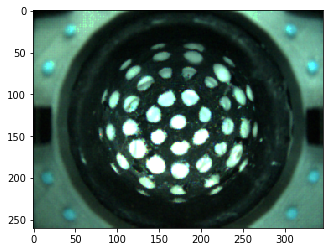

In [6]:
plt.imshow(frames[11])
plt.show()

In [7]:
#interpolate contact status to meet proper time
# f = interp1d(contact_case_ts, contact_case, kind='previous')
f = interp1d(contact_case_ts, contact_case, kind='nearest') # previous is not supported anymore (nearest)

frame_ts_start_idx = np.min(np.nonzero([i > np.min(contact_case_ts) for i in frames_ts]))
frame_ts_end_idx = np.max(np.nonzero([i < np.max(contact_case_ts) for i in frames_ts]))
frame_ts_idx_org = range(frame_ts_start_idx, frame_ts_end_idx)
frame_ts_idx = [idx for idx in frame_ts_idx_org if idx % 3 == 0]

contact_case_ts_int = [frames_ts[idx] for idx in frame_ts_idx]
contact_case_int = f(contact_case_ts_int)
frames_int = [np.copy(frames[idx]) for idx in frame_ts_idx]

In [8]:
del frames

In [9]:
import gc
gc.collect()

2448

In [10]:
print(np.shape(frames_int))

(2480, 260, 346, 3)


40
7482


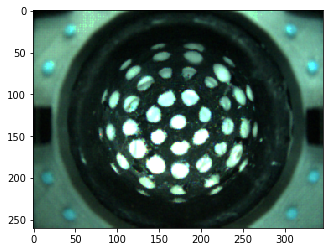

In [11]:
plt.imshow(frames_int[11])
print(frame_ts_start_idx)
print(frame_ts_end_idx)
plt.show()

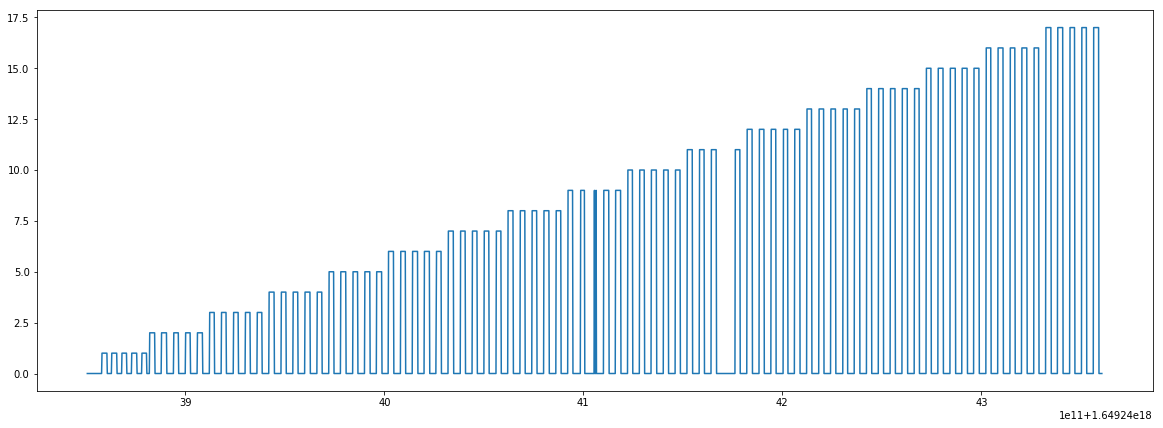

2480
2480


In [12]:
plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))
print(len(frames_int))

In [13]:
del EventPreProcess
import EventPreProcess
reload(EventPreProcess)
from EventPreProcess import EventPreProcess

In [14]:
#Generate frames, crop and and store in h5 file
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    cropped_image = EventPreProcess.cropFrames(frames_int[start_idx:end_idx], circle_center=(175, 130), circle_rad=100, im_channels=3, expand_dims=False) # adjust to center

    #write data
    if i==0:
        print(np.shape(cropped_image))
        hf.create_dataset('frames', data=cropped_image, maxshape=(None,None, None, None))
    else:
        hf['frames'].resize(len(hf['frames']) + len(cropped_image), axis=0)
        hf["frames"][-len(cropped_image):] = cropped_image
    del cropped_image

del frames_int
hf.close()

(1000, 260, 346, 3)


In [15]:
# del frames_int # deleted above

In [16]:
import gc
gc.collect()

4796

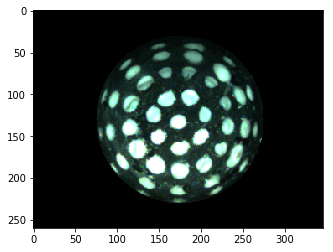

In [17]:
hf = h5py.File(h5_file_name, 'r')
fig = plt.figure()
plt.imshow(hf['frames'][100]/255)
plt.show()
fig.savefig('center.png')
hf.close()

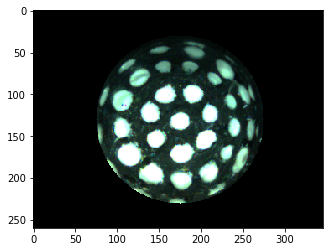

3.0
[7]


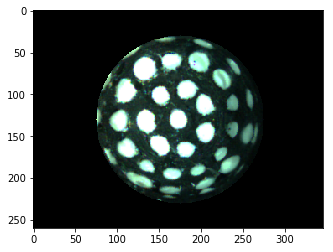

In [18]:
#Test camera rotation for augmentation
hf = h5py.File(h5_file_name, 'r+')
desired_status = 3
encounter = np.min(np.nonzero([i == desired_status for i in hf['contact_status']]))+10

original_image = hf['frames'][encounter]
original_contact_status = hf['contact_status'][encounter]
rot_90_image = EventPreProcess.rotateFrames([original_image], circle_center=(175, 130), rotate_angle=270) # changed from 177 to 175
rot_90_contact_status = EventPreProcess.updateContactStatus([original_contact_status], list_of_rotations, 270)

plt.imshow((original_image) / 255)
plt.show()
print(original_contact_status)
print(rot_90_contact_status)
plt.imshow((rot_90_image[0])/255)
plt.show()
hf.close()

In [19]:
#Augment images with rotation
hf = h5py.File(h5_file_name, 'r+')
set_size = 300

for i in range(0, len(hf['frames']), set_size):
    start_idx=i
    end_idx=min([len(hf['frames']), i+set_size])

    original_image = hf['frames'][start_idx:end_idx]
    original_contact_status = hf['contact_status'][start_idx:end_idx]

    rot_90_image = EventPreProcess.rotateFrames(original_image, circle_center=(177, 130), rotate_angle=90)
    rot_90_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 90)

    rot_180_image = EventPreProcess.rotateFrames(original_image, circle_center=(177, 130), rotate_angle=180)
    rot_180_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 180)

    rot_270_image = EventPreProcess.rotateFrames(original_image, circle_center=(177, 125), rotate_angle=270)
    rot_270_contact_status = EventPreProcess.updateContactStatus(original_contact_status, list_of_rotations, 270)


    #write data
    if i==0:
        hf.create_dataset('frames_augmented', data=np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0), maxshape=(None,None, None, None))
        hf.create_dataset('contact_status_augmented', data=np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0), maxshape=(None,))
    else:
        hf['frames_augmented'].resize(len(hf['frames_augmented']) + 4*len(original_image), axis=0)
        hf["frames_augmented"][-4*len(original_image):] = np.concatenate((original_image, rot_90_image, rot_180_image, rot_270_image), axis=0)

        hf['contact_status_augmented'].resize(len(hf['contact_status_augmented']) + 4*len(original_contact_status), axis=0)
        hf["contact_status_augmented"][-4*len(original_contact_status):] = np.concatenate((original_contact_status, rot_90_contact_status, rot_180_contact_status, rot_270_contact_status), axis=0)
    
    del rot_270_image, rot_180_image, rot_90_image, original_image
    del rot_270_contact_status, rot_180_contact_status, rot_90_contact_status, original_contact_status

hf.close()

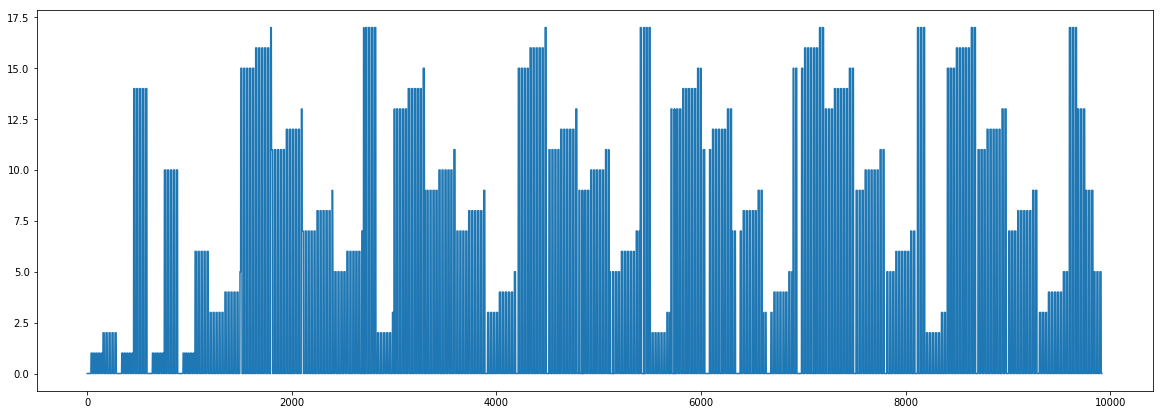

In [20]:
hf = h5py.File(h5_file_name, 'r')
plt.figure(figsize=(20,7))
plt.plot(hf["contact_status_augmented"])
plt.show()
hf.close()

In [21]:
hf = h5py.File(h5_file_name, 'r+')
print('number of total frames: {}'.format(len(hf['contact_status_augmented'])))
hf.close()

number of total frames: 9920


In [22]:
#Find rise/drop time and create windows accordingle
#Only take a sinle exmple from each case
hf = h5py.File(h5_file_name, 'r+')
edge_locations = np.where(np.diff(hf['contact_status_augmented'])>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)
hf.close()

[35, 59, 84, 108, 133, 152, 181, 211, 240, 269, 335, 359, 384, 408, 433, 452, 481, 511, 540, 569, 635, 659, 684, 708, 733, 752, 781, 811, 840, 869, 935, 959, 984, 1008, 1033, 1052, 1081, 1111, 1140, 1169, 1199, 1228, 1257, 1286, 1315, 1344, 1374, 1403, 1432, 1462, 1491, 1499, 1528, 1557, 1586, 1615, 1644, 1674, 1703, 1732, 1762, 1791, 1828, 1857, 1886, 1915, 1944, 1974, 2003, 2032, 2062, 2091, 2128, 2157, 2186, 2215, 2244, 2274, 2303, 2332, 2362, 2391, 2419, 2449, 2478, 2507, 2536, 2566, 2595, 2624, 2653, 2682, 2699, 2719, 2749, 2778, 2807, 2836, 2866, 2895, 2924, 2953, 2982, 2999, 3019, 3049, 3078, 3107, 3136, 3166, 3195, 3224, 3253, 3282, 3299, 3319, 3349, 3378, 3407, 3436, 3466, 3495, 3524, 3553, 3582, 3612, 3641, 3670, 3699, 3727, 3757, 3786, 3815, 3845, 3874, 3912, 3941, 3970, 3999, 4027, 4057, 4086, 4115, 4145, 4174, 4212, 4241, 4270, 4299, 4327, 4357, 4386, 4415, 4445, 4474, 4512, 4541, 4570, 4599, 4627, 4657, 4686, 4715, 4745, 4774, 4805, 4838, 4842, 4861, 4890, 4920, 4949, 497

0.0


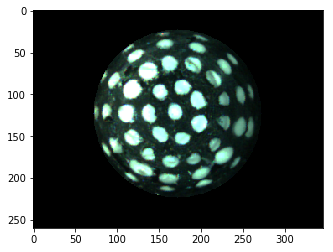

In [23]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 9919
plt.imshow(hf['frames_augmented'][indx]/255)
print(hf['contact_status_augmented'][indx])
plt.show
hf.close()

[5812, 252, 248, 233, 247, 236, 248, 233, 247, 236, 248, 233, 247, 236, 248, 233, 247, 236]


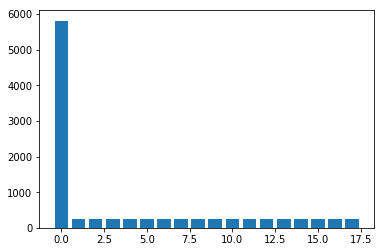

In [24]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['contact_status_augmented'])):
    idx = int(hf['contact_status_augmented'][i])
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [25]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['frames_augmented'])):
        idx = int(hf['contact_status_augmented'][i])
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'frames_augmented_equalized' in hf_file.keys():
                hf_file['frames_augmented_equalized'].resize(len(hf_file['frames_augmented_equalized']) + 1, axis=0)
                hf_file["frames_augmented_equalized"][len(hf_file['frames_augmented_equalized'])-1] = hf_file['frames_augmented'][i]

                hf_file['contact_status_augmented_equalized'].resize(len(hf_file['contact_status_augmented_equalized']) + 1, axis=0)
                hf_file["contact_status_augmented_equalized"][len(hf_file['contact_status_augmented_equalized'])-1] = hf_file['contact_status_augmented'][i]
            else:
                hf_file.create_dataset('frames_augmented_equalized', data=[hf_file['frames_augmented'][i]], maxshape=(None,None, None, None))
                hf_file.create_dataset('contact_status_augmented_equalized', data=[hf_file['contact_status_augmented'][i]], maxshape=(None,))

equalize_representation(hf, counter)

[1453, 63, 63, 60, 62, 63, 63, 61, 62, 50, 61, 49, 61, 60, 61, 63, 62, 63]


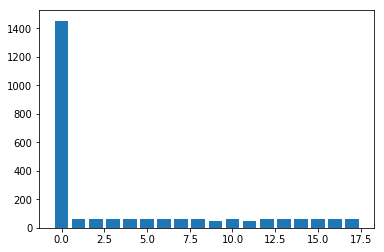

In [26]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['contact_status'])):
    idx = int(hf['contact_status'][i])
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [27]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['frames'])):
        idx = int(hf['contact_status'][i])
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'frames_augmented_equalized' in hf_file.keys():
                hf_file['frames_augmented_equalized'].resize(len(hf_file['frames_augmented_equalized']) + 1, axis=0)
                hf_file["frames_augmented_equalized"][len(hf_file['frames_augmented_equalized'])-1] = hf_file['frames'][i]

                hf_file['contact_status_augmented_equalized'].resize(len(hf_file['contact_status_augmented_equalized']) + 1, axis=0)
                hf_file["contact_status_augmented_equalized"][len(hf_file['contact_status_augmented_equalized'])-1] = hf_file['contact_status'][i]
            else:
                hf_file.create_dataset('frames_augmented_equalized', data=[hf_file['frames'][i]], maxshape=(None,None, None, None))
                hf_file.create_dataset('contact_status_augmented_equalized', data=[hf_file['contact_status'][i]], maxshape=(None,))

equalize_representation(hf, counter)

[287, 281, 283, 283, 278, 281, 278, 282, 281, 284, 286, 282, 279, 281, 280, 286, 276, 285]


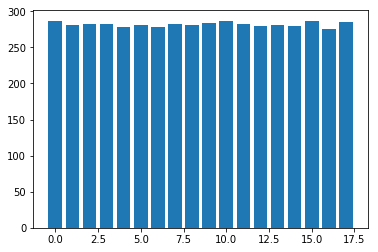

In [28]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
new_counter = [0] * 18

for i in range(len(hf['contact_status_augmented_equalized'])):
    idx = int(hf['contact_status_augmented_equalized'][i])
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)
hf.close()

[1453, 63, 63, 60, 62, 63, 63, 61, 62, 50, 61, 49, 61, 60, 61, 63, 62, 63]


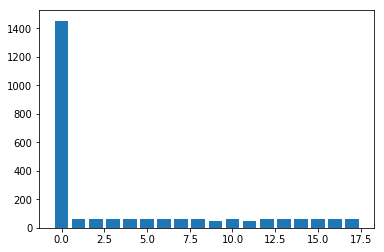

In [29]:
## RAW DATA
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['frames'])):
        idx = int(hf['contact_status'][i])
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'frames_equalized' in hf_file.keys():
                hf_file['frames_equalized'].resize(len(hf_file['frames_equalized']) + 1, axis=0)
                hf_file["frames_equalized"][len(hf_file['frames_equalized'])-1] = hf_file['frames'][i]

                hf_file['contact_status_equalized'].resize(len(hf_file['contact_status_equalized']) + 1, axis=0)
                hf_file["contact_status_equalized"][len(hf_file['contact_status_equalized'])-1] = hf_file['contact_status'][i]
            else:
                hf_file.create_dataset('frames_equalized', data=[hf_file['frames'][i]], maxshape=(None,None, None, None))
                hf_file.create_dataset('contact_status_equalized', data=[hf_file['contact_status'][i]], maxshape=(None,))

equalize_representation(hf, counter)

#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['contact_status'])):
    idx = int(hf['contact_status'][i])
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()


[99, 101, 97, 94, 87, 101, 106, 100, 93, 100, 104, 98, 104, 98, 99, 94, 98, 94]


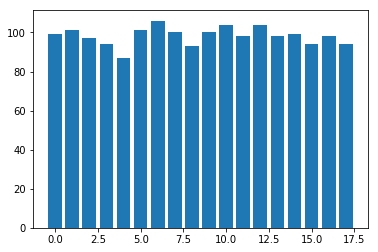

In [30]:

#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(1, len(hf_file['frames'])):
        idx = int(hf['contact_status'][i])
        
        if (np.random.rand() < (float(min(counter[1:])) / counter[idx])):
            if 'frames_equalized' in hf_file.keys():
                hf_file['frames_equalized'].resize(len(hf_file['frames_equalized']) + 1, axis=0)
                hf_file["frames_equalized"][len(hf_file['frames_equalized'])-1] = hf_file['frames'][i]

                hf_file['contact_status_equalized'].resize(len(hf_file['contact_status_equalized']) + 1, axis=0)
                hf_file["contact_status_equalized"][len(hf_file['contact_status_equalized'])-1] = hf_file['contact_status'][i]
            else:
                hf_file.create_dataset('frames_equalized', data=[hf_file['frames'][i]], maxshape=(None,None, None, None))
                hf_file.create_dataset('contact_status_equalized', data=[hf_file['contact_status'][i]], maxshape=(None,))

equalize_representation(hf, counter)

#analyze classes
hf = h5py.File(h5_file_name, 'r+')
new_counter = [0] * 18

for i in range(len(hf['contact_status_equalized'])):
    idx = int(hf['contact_status_equalized'][i])
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)
hf.close()

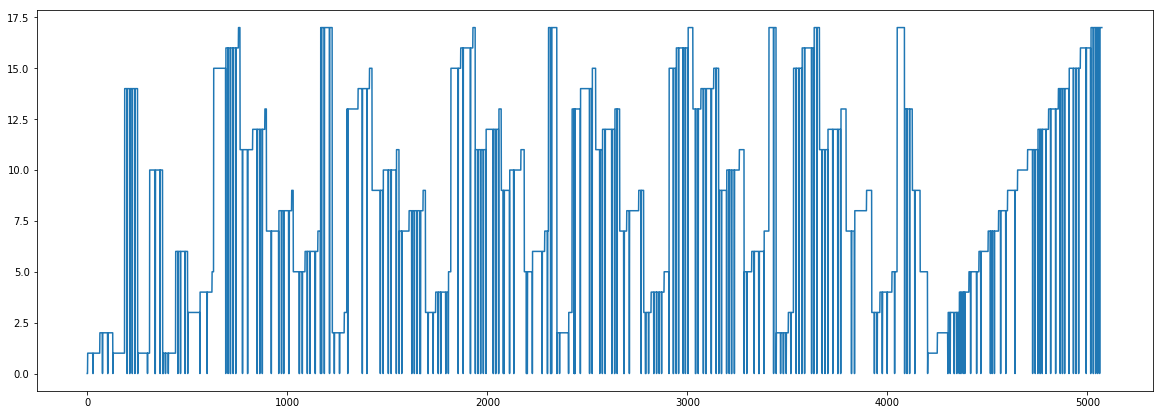

In [31]:
hf = h5py.File(h5_file_name, 'r')
plt.figure(figsize=(20,7))
plt.plot(hf["contact_status_augmented_equalized"])
plt.show()
hf.close()

17.0


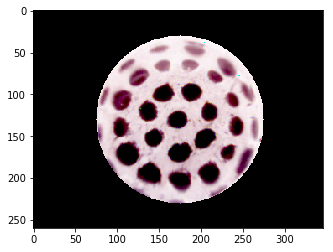

In [32]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
# indx = 9000
indx = (hf['frames_augmented_equalized'].shape[0]) - 1
plt.imshow(hf['frames_augmented_equalized'][indx])
print(hf['contact_status_augmented_equalized'][indx])
plt.show
hf.close()

In [33]:
hf = h5py.File(h5_file_name, 'r+')
print(len(hf['contact_status_augmented_equalized']))

5073


In [34]:
hf.close()

[2341, 2370, 2400, 2429, 2458]


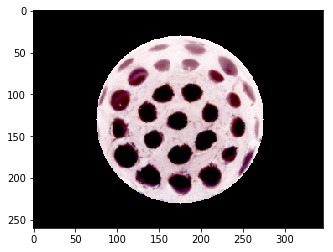

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


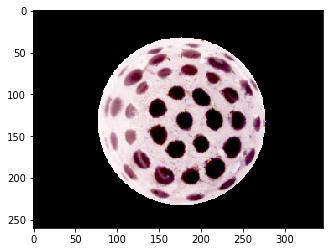

In [35]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 17
idx = 0
increment = 10

edge_locations = np.where(np.multiply(np.diff(hf['contact_status'])>0, np.equal(np.array(hf['contact_status']), desired_class * np.ones(shape=np.shape(hf['contact_status'])))[1:] ))
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

plt.imshow(hf['frames'][edge_locations[idx]+increment])
plt.show()

idx = 5

edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
print(edge_locations_augmented)

plt.imshow(hf['frames_augmented'][edge_locations_augmented[idx]+increment])
plt.show()

hf.close()

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


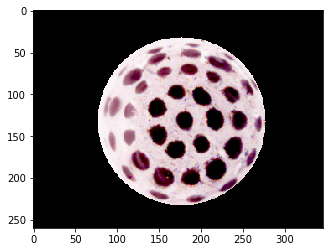

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


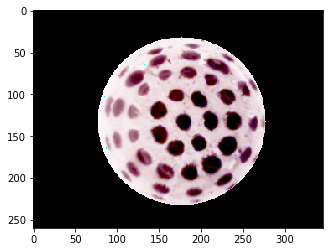

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


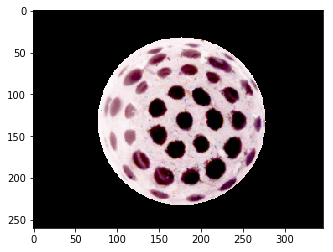

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


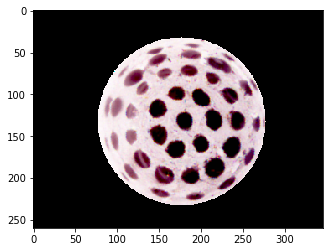

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


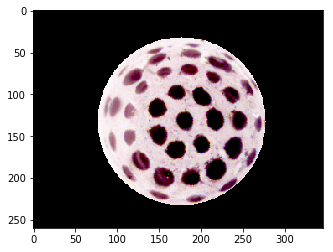

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


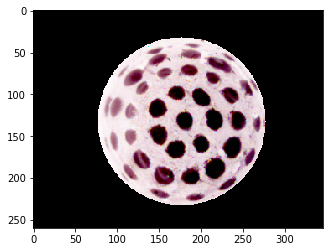

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


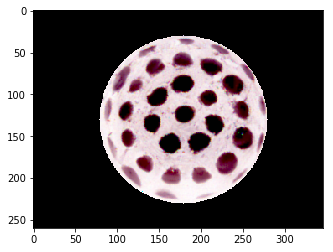

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


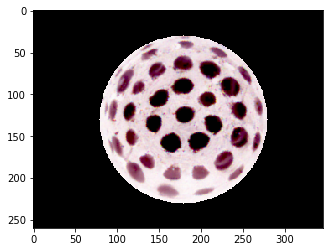

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


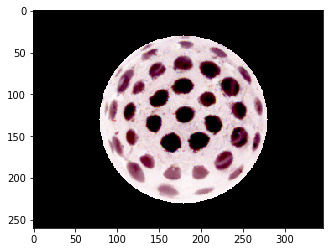

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


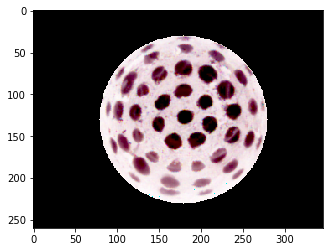

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


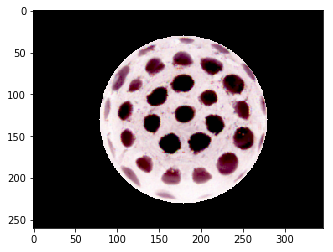

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


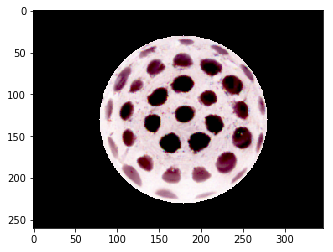

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


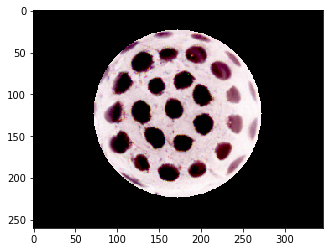

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


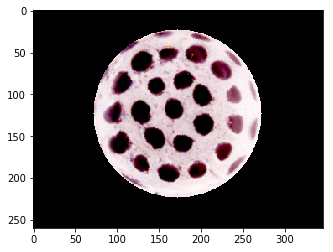

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


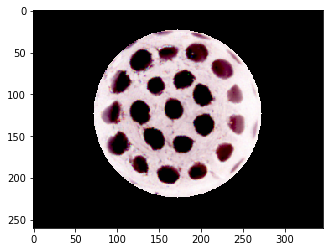

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


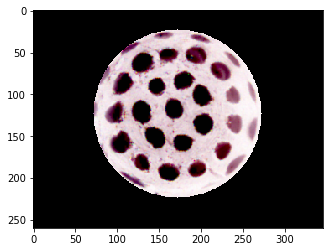

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


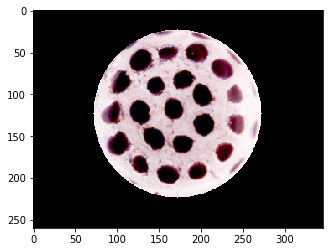

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


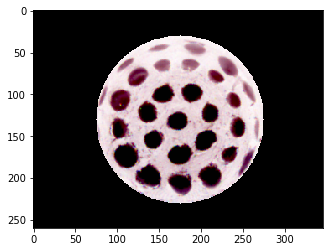

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


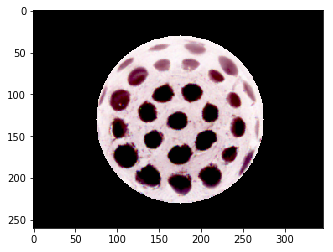

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


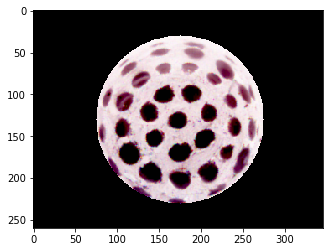

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


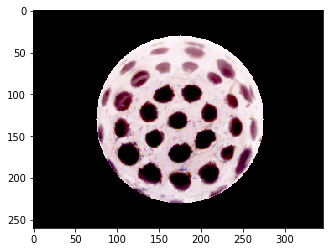

[1791, 2699, 2719, 2749, 2778, 2807, 4474, 5405, 5438, 5442, 5461, 5490, 7157, 7186, 8115, 8145, 8173, 8641, 8670, 9600, 9629, 9658]


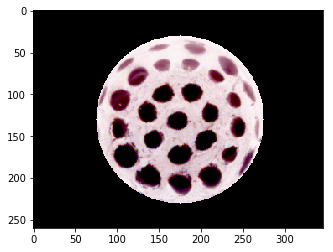

In [36]:
#compare augmented data with regular images
hf = h5py.File(h5_file_name, 'r')
desired_class = 17
increment = 5

for idx in range(len(edge_locations_augmented)):

    edge_locations_augmented = np.where(np.multiply(np.diff(hf['contact_status_augmented'])>0, np.equal(np.array(hf['contact_status_augmented']), desired_class * np.ones(shape=np.shape(hf['contact_status_augmented'])))[1:] ))
    edge_locations_augmented = np.array(edge_locations_augmented)[0].tolist()
    print(edge_locations_augmented)

    plt.imshow(hf['frames_augmented'][edge_locations_augmented[idx]+increment])
    plt.show()

hf.close()

In [37]:
hf = h5py.File(h5_file_name, 'r+')
# print(np.mean(hf['event_images'][:,:,:,0]))
# print(np.std(hf['event_images'][:,:,:,0]))
# print(np.max(hf['event_images'][:,:,:,0]))
# print(np.min(hf['event_images'][:,:,:,0]))
# hf.close

In [38]:
hf.keys()

[u'contact_status',
 u'contact_status_augmented',
 u'contact_status_augmented_equalized',
 u'contact_status_equalized',
 u'frames',
 u'frames_augmented',
 u'frames_augmented_equalized',
 u'frames_equalized',
 u'time_steps']

In [63]:
print(np.mean(hf['frames'][:,:,:,0]))
print(np.std(hf['frames'][:,:,:,0]))
print(np.max(hf['frames'][:,:,:,0]))
print(np.min(hf['frames'][:,:,:,0]))

21.8767
52.2954
255.0
0.0


In [65]:
print(np.mean(hf['frames_augmented'][:,:,:,0]))
print(np.std(hf['frames_augmented'][:,:,:,0]))
print(np.max(hf['frames_augmented'][:,:,:,0]))
print(np.min(hf['frames_augmented'][:,:,:,0]))

21.8769
52.2966
255.0
0.0


In [66]:
print(np.mean(hf['frames_augmented_equalized'][:,:,:,0]))
print(np.std(hf['frames_augmented_equalized'][:,:,:,0]))
print(np.max(hf['frames_augmented_equalized'][:,:,:,0]))
print(np.min(hf['frames_augmented_equalized'][:,:,:,0]))

22.7271
54.2719
255.0
0.0


In [39]:
hf.close()